In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import pandas as pd
pd.set_option("display.max_columns", 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix

In [12]:
from utils import cost_function, coster, get_scores

In [3]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()
df = pd.DataFrame(cursor.execute("""select * from combined5""").fetchall())
df.columns = [description[0] for description in cursor.description]
df = df.drop(columns=["index", "level_0"])
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,plant_name_gen,operator_name_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month_nerc,number_affected,disturbance_events
0,5.4,23.100,0.0,0.49,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,259412,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
1,5.7,22.800,0.0,0.48,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,52241,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
2,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,3433,3433,3559,3559,1609033,2008,2400,2400,1.04,2489,2489,146327,2008-1-SERC,0.0,0.0
3,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,30932077,30932077,32090118,32090118,2858195,2008,2781102,2781102,1.04,2884003,2884003,244784,2008-1-SERC,0.0,0.0
4,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,837652,837652,871270,871270,87265,2008,109281,109281,1.04,113543,113543,11487,2008-1-SERC,0.0,0.0


In [4]:
ng_fields = [ 'contract_type', 'fuel_cost', 'natural_gas_delivery_contract_type', 'natural_gas_supply_contract_type', 'natural_gas_transportation_service', 'operator_id',  'plant_id', 'plant_state', 'primary_transportation_mode', 'purchase_type', 'quantity', 'regulated', "reporting_frequency", "secondary_transportation_mode", "supplier", "combined_heat_and_power_plant", "nerc_region", "reported_prime_mover", "mmbtu_per_unit_gen", "disturbance_events", "number_affected", "net_generation_megawatthours"]

# Checking Correlations

In [6]:
# Label encode categorical fields so that they can be correlated
df_ng = df[df["fuel_group"] == "Natural Gas"][ng_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_ng[ng_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_ng[not_encode].reset_index()
temp2 = df_ng[to_encode].apply(le.fit_transform).reset_index()
df_ng = temp1.merge(temp2, on="index").set_index("index")

In [7]:
corr = df_ng.corr()

In [8]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['natural_gas_delivery_contract_type',
  'natural_gas_supply_contract_type',
  0.9949670257245146],
 ['natural_gas_supply_contract_type',
  'natural_gas_delivery_contract_type',
  0.9949670257245146],
 ['disturbance_events', 'number_affected', 0.7655082998226197],
 ['number_affected', 'disturbance_events', 0.7655082998226197],
 ['mmbtu_per_unit_gen', 'reported_prime_mover', 0.4551813724903194],
 ['natural_gas_transportation_service', 'purchase_type', 0.375298202366619],
 ['purchase_type', 'natural_gas_transportation_service', 0.375298202366619],
 ['contract_type', 'natural_gas_delivery_contract_type', 0.35006057060938583],
 ['natural_gas_delivery_contract_type', 'contract_type', 0.35006057060938583],
 ['contract_type', 'natural_gas_supply_contract_type', 0.34927582099496446],
 ['natural_gas_supply_contract_type', 'contract_type', 0.34927582099496446],
 ['primary_transportation_mode', 'purchase_type', 0.2942462825380524],
 ['purchase_type', 'primary_transportation_mode', 0.294246282538

Some obvious correlations in here, like gas supply and delivery contract type or disturbance events and number affected (by disturbance events). It helps give an idea of the data, btu it doesn't indicate any changes to features.

### Checking Correlations Involving Fuel Cost

In [9]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'number_affected', 0.016547105838107864],
 ['fuel_cost', 'regulated', nan],
 ['number_affected', 'fuel_cost', 0.016547105838107864],
 ['fuel_cost', 'disturbance_events', 0.008163806819898293],
 ['disturbance_events', 'fuel_cost', 0.008163806819898293],
 ['fuel_cost', 'reporting_frequency', 0.005495275823372207],
 ['reporting_frequency', 'fuel_cost', 0.005495275823372207],
 ['fuel_cost', 'nerc_region', 0.00423735556784291],
 ['nerc_region', 'fuel_cost', 0.00423735556784291],
 ['fuel_cost', 'plant_id', 0.003095974637123335],
 ['plant_id', 'fuel_cost', 0.003095974637123335],
 ['fuel_cost', 'primary_transportation_mode', 0.002930004254140046],
 ['primary_transportation_mode', 'fuel_cost', 0.002930004254140046],
 ['fuel_cost', 'supplier', 0.00274519529513206],
 ['supplier', 'fuel_cost', 0.00274519529513206],
 ['fuel_cost', 'natural_gas_supply_contract_type', 0.0006275626240884574],
 ['natural_gas_supply_contract_type', 'fuel_cost', 0.0006275626240884574],
 ['fuel_cost', 'natu

Interesting that disturbance events and number affected are correlated to fuel cost, but the correlation is not high. Same for other correlations: interesting but not strong enough to infer anything. On to modelling.

# Modelling

In [5]:
def get_ng():
    df_ng = df[df["fuel_group"] == "Natural Gas"][ng_fields]
    not_encode = []
    to_encode = []
    for fld, fld_type in df_ng[ng_fields].dtypes.items():
        if "object" == fld_type:
            to_encode.append(fld)
        else:
            not_encode.append(fld)
    temp1 = df_ng[not_encode].reset_index()
    temp2 = pd.get_dummies(df_ng[to_encode]).reset_index()
    df_ng = temp1.merge(temp2, on="index").set_index("index")
    return df_ng

In [6]:
def get_xy():
    X = df_ng.drop(columns=["fuel_cost"])
    y = (df_ng.fuel_cost > df_ng.fuel_cost.quantile(.9))
    return X, y

## Decision Tree

In [21]:
df_ng = get_ng()
X, y = get_xy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, criterion='entropy')
results = model.fit(X_train, y_train)

In [8]:
results.score(X_test, y_test)

0.938257808571269

Decent score for accuracy, indicating better than baseline == "no price spikes" for the imbalanced model (p=.9). But f1 score will be the better determinant.

In [35]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.7042440318302388
Recall: 0.6898663697104677
F1: 0.6969810613163323
       0     1
0  46742  1561
1   1671  3717
Cost Function: -0.05152824772769761


Decent. All scores around 70 is not bad. Cost function is negative indicating a net benefit to  using the model.

In [36]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.13116271472517899
Recall: 0.8975409836065574
F1: 0.22887817391510892
       0      1
0  16408  31915
1    550   4818
Cost Function: -0.045733199006608286
       0      1
0  16408  31915
1    550   4818
Precision: 0.2932187201528176
Recall: 0.5719076005961252
F1: 0.38767521151660567
       0     1
0  40923  7400
1   2298  3070
Cost Function: -0.028963887037280468
       0     1
0  40923  7400
1   2298  3070
Precision: 0.4806255430060817
Recall: 0.5152757078986587
F1: 0.4973478378135395
       0     1
0  45334  2989
1   2602  2766
Cost Function: -0.05195178833374639
       0     1
0  45334  2989
1   2602  2766
Precision: 0.4112734864300626
Recall: 0.256892697466468
F1: 0.31624813668157326
       0     1
0  46349  1974
1   3989  1379
Cost Function: -0.06525568395713448
       0     1
0  46349  1974
1   3989  1379
Precision: 0.35686509123541726
Recall: 0.2222429210134128
F1: 0.27390655493054755
       0     1
0  46172  2150
1   4175  1193
Cost Function: -0.01856574984077382
  

array([-0.0457332 , -0.02896389, -0.05195179, -0.06525568, -0.01856575])

In [37]:
np.mean([-0.0457332 , -0.02896389, -0.05195179, -0.06525568, -0.01856575])

-0.042094062

In [38]:
sum(df_ng.quantity) * -0.042094062

-4076160920.5935607

In [39]:
cross_val_score(results, X, y, scoring=coster, cv=30)

Precision: 0.12302890932982917
Recall: 0.8368715083798882
F1: 0.21452097952169555
      0     1
0  2715  5339
1   146   749
Cost Function: -0.09338815262041558
      0     1
0  2715  5339
1   146   749
Precision: 0.1707126076742365
Recall: 0.7307262569832402
F1: 0.27676682183664836
      0     1
0  4877  3177
1   241   654
Cost Function: -0.11724830083914031
      0     1
0  4877  3177
1   241   654
Precision: 0.584070796460177
Recall: 0.6636871508379888
F1: 0.6213389121338913
      0    1
0  7631  423
1   301  594
Cost Function: -0.09532760700235461
      0    1
0  7631  423
1   301  594
Precision: 0.47647647647647645
Recall: 0.5318435754189944
F1: 0.5026399155227032
      0    1
0  7531  523
1   419  476
Cost Function: -0.04656126225825481
      0    1
0  7531  523
1   419  476
Precision: 0.49589322381930184
Recall: 0.5396648044692738
F1: 0.5168539325842697
      0    1
0  7563  491
1   412  483
Cost Function: -0.08943883104106595
      0    1
0  7563  491
1   412  483
Precision: 0.3

array([-0.09338815, -0.1172483 , -0.09532761, -0.04656126, -0.08943883,
       -0.03377804, -0.01489992, -0.04762788, -0.02763839, -0.05677785,
       -0.04199548, -0.01713666, -0.06249259, -0.04621697, -0.02309106,
       -0.07504379, -0.03561104, -0.08115665, -0.08066301, -0.09566374,
       -0.05040187, -0.03420523, -0.05032998, -0.06507986, -0.00900975,
       -0.00063877, -0.05234767, -0.01943309, -0.02632712, -0.01091636])

In [40]:
np.mean([-0.09338815, -0.1172483 , -0.09532761, -0.04656126, -0.08943883,
       -0.03377804, -0.01489992, -0.04762788, -0.02763839, -0.05677785,
       -0.04199548, -0.01713666, -0.06249259, -0.04621697, -0.02309106,
       -0.07504379, -0.03561104, -0.08115665, -0.08066301, -0.09566374,
       -0.05040187, -0.03420523, -0.05032998, -0.06507986, -0.00900975,
       -0.00063877, -0.05234767, -0.01943309, -0.02632712, -0.01091636])

-0.05001489733333332

# Trying Different Cutoff Thesholds

In [48]:
df_ng = get_ng()
X = df_ng.drop(columns=["fuel_cost"])

for cutoff in [.8, .85, .9, .95, .99]:
    y = (df_ng.fuel_cost > df_ng.fuel_cost.quantile(cutoff))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    model = DecisionTreeClassifier(random_state=23, criterion='entropy')
    results = model.fit(X_train, y_train)
    y_pred = results.predict(X_test)
    get_scores(y_test, y_pred, X_test)
    

Precision: 0.783563718992615
Recall: 0.7734579439252336
F1: 0.7784780359326497
       0     1
0  40705  2286
1   2424  8276
Cost Function: -0.11831184418460877
Precision: 0.7680020283975659
Recall: 0.7581977471839799
F1: 0.7630683965234917
       0     1
0  43871  1830
1   1932  6058
Cost Function: -0.08041131426850526
Precision: 0.6982515510434292
Recall: 0.6969412647776319
F1: 0.6975957926371149
       0     1
0  46757  1605
1   1615  3714
Cost Function: -0.04685456535875492
Precision: 0.577818853974122
Recall: 0.5963372758489126
F1: 0.5869320315433721
       0     1
0  49928  1142
1   1058  1563
Cost Function: -0.015292740288847901
Precision: 0.7903225806451613
Recall: 0.735
F1: 0.7616580310880828
       0    1
0  52974  117
1    159  441
Cost Function: -0.0005302167548820255


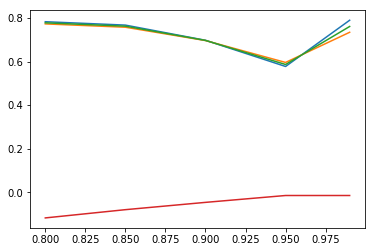

In [55]:
precision = [0.783563718992615, 0.7680020283975659,  0.6982515510434292,   0.577818853974122, 0.7903225806451613]
recall = [0.7734579439252336, 0.7581977471839799, 0.6969412647776319, 0.5963372758489126, 0.735]
f1 = [0.7784780359326497, 0.7630683965234917, 0.6975957926371149, 0.5869320315433721, 0.7616580310880828]
cost = [-0.11831184418460877, -0.08041131426850526, -0.04685456535875492, -0.015292740288847901, -0.015292740288847901]
cutoffs = [.8, .85, .9, .95, .99]
plt.plot(cutoffs, precision)
plt.plot(cutoffs, recall)
plt.plot(cutoffs, f1)
plt.plot(cutoffs, cost)

Maybe .8 is a better cutoff

In [49]:
df_ng = get_ng()
X = df_ng.drop(columns=["fuel_cost"])

y = (df_ng.fuel_cost > df_ng.fuel_cost.quantile(.8))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, criterion='entropy')
results = model.fit(X_train, y_train)

In [50]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.2718140307181403
Recall: 0.9159750069943113
F1: 0.41922403858466006
       0      1
0  16655  26313
1    901   9822
Cost Function: -0.10568130662776964
       0      1
0  16655  26313
1    901   9822
Precision: 0.41654308782336463
Recall: 0.7072647579968292
F1: 0.5243000345661942
       0      1
0  32345  10623
1   3139   7584
Cost Function: -0.07503904294477658
       0      1
0  32345  10623
1   3139   7584
Precision: 0.47878116343490307
Recall: 0.40296558798843607
F1: 0.43761393558841405
       0     1
0  38264  4704
1   6402  4321
Cost Function: -0.11024717707275188
       0     1
0  38264  4704
1   6402  4321
Precision: 0.3355525965379494
Recall: 0.16450620162268023
F1: 0.22077596996245308
       0     1
0  39475  3493
1   8959  1764
Cost Function: -0.11215052918732706
       0     1
0  39475  3493
1   8959  1764
Precision: 0.48024184841286977
Recall: 0.4148479761238575
F1: 0.4451561248999199
       0     1
0  38154  4814
1   6274  4448
Cost Function: -0.2510829557473

array([-0.10568131, -0.07503904, -0.11024718, -0.11215053, -0.25108296])

In [51]:
results.score(X_test, y_test)

0.9099662885772289

In [53]:
df_ng.fuel_cost.quantile(.8)

604.0

Scoring is generally worse here, but cost is great. Possible that quantity is really affecting outcome of cost function.

# Feature Analysis

In [232]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

quantity 0.2639298532196594
net_generation_megawatthours 0.16681981916677763
primary_transportation_mode_PL 0.059156543020373924
mmbtu_per_unit_gen 0.040228505837030755
disturbance_events 0.014906923145290261
purchase_type_N/A 0.01316632585737791
operator_id_16534.0 0.012635394716005995
supplier_VARIOUS 0.00971207734557755
plant_id_7314 0.008714524169864665
operator_id_15474.0 0.007566184455746114
contract_type_C 0.007157665243566569
operator_id_19876.0 0.007130747991459389
contract_type_S 0.0063189426896943434
plant_state_CA 0.006184559898135931
reporting_frequency_M 0.006137612931740958
natural_gas_transportation_service_F 0.0058624950443495055
number_affected 0.005840093323124269
operator_id_11249.0 0.005643361016537877
plant_id_56328 0.005590504971553016
operator_id_16572.0 0.005586322537720061
supplier_SHELL ENERGY NORTH AMERICA 0.005212109609028521
plant_state_OK 0.0048970895498224466
natural_gas_transportation_service_I 0.004875437405651156
plant_state_TX 0.004260917068465454
re

supplier_EDF 0.00014015904709287522
operator_id_814.0 0.00014007405781769327
operator_id_17568.0 0.00013992749408381325
plant_id_2517 0.00013992357448104514
plant_id_673 0.00013980869923950975
supplier_PNMR 0.00013947184582467485
plant_id_56013 0.0001393333760478173
supplier_NWPL 0.00013824334519430486
supplier_PAIUTE 0.00013714636860960396
supplier_EXELON 0.0001371396321633617
plant_id_26 0.00013590602118342444
supplier_MUNICH RE TRADING 0.00013502843916024396
plant_id_7946 0.00013477485824810943
plant_id_7032 0.00013461600677097514
supplier_COLUMBIA GULF TRANSMISSION 0.000134398132499227
operator_id_40229.0 0.00013408279222454285
plant_state_MA 0.0001338507838422429
plant_id_2079 0.00013253223033230684
combined_heat_and_power_plant_N 0.00013216248428837314
plant_id_6046 0.00013120139498343008
supplier_Odyssey 0.0001308403948151063
plant_id_7839 0.00012949253759561607
supplier_NGPL 0.00012829936508357306
plant_id_1167 0.00012797908853848984
plant_id_8054 0.00012788743059139672
supplie

operator_id_3355.0 0.0
operator_id_3486.0 0.0
operator_id_3522.0 0.0
operator_id_3542.0 0.0
operator_id_3702.0 0.0
operator_id_3892.0 0.0
operator_id_39347.0 0.0
operator_id_40211.0 0.0
operator_id_40307.0 0.0
operator_id_4045.0 0.0
operator_id_40613.0 0.0
operator_id_40614.0 0.0
operator_id_4062.0 0.0
operator_id_4180.0 0.0
operator_id_4363.0 0.0
operator_id_50111.0 0.0
operator_id_50168.0 0.0
operator_id_50172.0 0.0
operator_id_5063.0 0.0
operator_id_5107.0 0.0
operator_id_5269.0 0.0
operator_id_5532.0 0.0
operator_id_5580.0 0.0
operator_id_55937.0 0.0
operator_id_55987.0 0.0
operator_id_56815.0 0.0
operator_id_57393.0 0.0
operator_id_599.0 0.0
operator_id_59917.0 0.0
operator_id_61919.0 0.0
operator_id_62032.0 0.0
operator_id_6204.0 0.0
operator_id_6526.0 0.0
operator_id_6775.0 0.0
operator_id_6779.0 0.0
operator_id_7349.0 0.0
operator_id_7483.0 0.0
operator_id_7490.0 0.0
operator_id_7634.0 0.0
operator_id_796.0 0.0
operator_id_8567.0 0.0
operator_id_8723.0 0.0
operator_id_8795.0 0.

# Removing Features

In [303]:
updated_fields = list(X.columns)
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    if b == 0:
        updated_fields.remove(a)

In [305]:
df_ng = get_ng()

X = df_ng.drop(columns=["fuel_cost"])
X = X[updated_fields]
y = (df_ng.fuel_cost > df_ng.fuel_cost.quantile(.9))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [306]:
model = DecisionTreeClassifier(random_state=23, criterion='entropy')
results = model.fit(X_train, y_train)

In [307]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.698632774889274
Recall: 0.6901274491154651
F1: 0.694354066985646
       0     1
0  46869  1565
1   1629  3628
Cost Function: -0.030526803942082265


Removing fields had no effect

# Analyze False Positives and Negatives

In [13]:
y_pred = results.predict(X)

In [14]:
wrongs = (y_pred != y)

In [15]:
df_ng["wrong"] = wrongs

In [17]:
df_ng["natural_gas_delivery_contract_type_N/A"].value_counts()

1    207599
0     60855
Name: natural_gas_delivery_contract_type_N/A, dtype: int64

In [16]:
df_ng[df_ng["wrong"] == True]["natural_gas_delivery_contract_type_N/A"].value_counts()

1    3031
0     187
Name: natural_gas_delivery_contract_type_N/A, dtype: int64

In [20]:
print(187/3031)
print(60855/207599)

0.061695809963708347
0.2931372501794325


After some trial and error, large number of incorrect values have a delivery contract of "N/A". Maybe we can subset the data of those values and use a separate model.

# Subsetting the Data  Part 1 - Where Delivery Contract != N/A

In [308]:
df_ng = get_ng()
df_ng2 = df_ng[(df_ng["natural_gas_delivery_contract_type_N/A"] != 1)]

In [297]:
len(df_ng2)

60855

In [309]:
X = df_ng2.drop(columns="fuel_cost")
y = (df_ng2.fuel_cost > df_ng.fuel_cost.quantile(.9))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [311]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.954248366013072
Recall: 0.35180722891566263
F1: 0.5140845070422535
       0    1
0  11749    7
1    269  146
Cost Function: -0.00032126552808189434


F1 score here is worse, as well as cost, as might be predicted. Although precision is good. 
Running cross_val to see more.
Something about when the delivery contract is known makes prices more unpredictable?

In [312]:
cross_val_score(results, X, y, scoring=coster, cv=5)

       0   1
0  11748  17
1    336  71
       0    1
0  11728   37
1    217  189
       0    1
0  11743   22
1    237  169
       0   1
0  11764   1
1    320  86
       0    1
0  11763    1
1    302  104


array([-0.00016631, -0.00036583, -0.00035015, -0.00014487, -0.00024024])

Good thing is very few false negatives, and all the cost values are negative, but not by much. 

In [67]:
y_pred = results.predict(X)

In [68]:
wrong = (y != y_pred)

In [69]:
df_ng2["wrong"] = wrong

/Users/lhinkesjones/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# Identify Features That Might Be Associated with Innaccurate Predictions
i.e. volatile predictors

In [70]:
df_ng4 = df_ng2[df_ng2["wrong"] == True]

In [206]:
other_cols = []
for col in df_ng4.columns:
    sum_ = df_ng4[col].sum()
    if sum_ >0: other_cols.append(col)


In [89]:
df_ng4[other_cols].sum().reset_index().sort_values(0, ascending=False)[0:50]

,index,0
1,quantity,1.728757e+08
0,fuel_cost,6.623665e+07
4,number_affected,5.058808e+06
10,natural_gas_transportation_service_N/A,1.353000e+03
347,secondary_transportation_mode_N/A,1.353000e+03
344,regulated_REG,1.353000e+03
340,primary_transportation_mode_PL,1.353000e+03
489,wrong,1.353000e+03
5,contract_type_N/A,1.353000e+03
471,combined_heat_and_power_plant_N,1.317000e+03


In [268]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["natural_gas_delivery_contract_type_F"] == 1) & \
              (df_ng["natural_gas_delivery_contract_type_N/A"] != 1)]
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.9))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

0.5309278350515464
      0    1
0  9043    1
1   181  103


0.9810677530017152

In [47]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["nerc_region_SERC"] != 1) & \
              (df_ng["natural_gas_delivery_contract_type_N/A"] != 1)]
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.9))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)
y_pred = results.predict(X_test)

get_scores(y_test, y_pred, X_test)


Precision: 0.9111111111111111
Recall: 0.47674418604651164
F1: 0.6259541984732825
      0    1
0  8449   12
1   135  123
Cost Function: -0.0032483153643423587


In [46]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["natural_gas_supply_contract_type_I"] == 1) & \
              (df_ng["natural_gas_delivery_contract_type_N/A"] != 1)]
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.9))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)



Precision: 0.7272727272727273
Recall: 0.41379310344827586
F1: 0.5274725274725275
      0   1
0  2911  18
1    68  48
Cost Function: -0.0027501330603776197


In [45]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["reporting_frequency_A"] == 1) & \
              (df_ng["natural_gas_delivery_contract_type_N/A"] != 1)]
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.9))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)


Precision: 0.898876404494382
Recall: 0.6201550387596899
F1: 0.7339449541284403
      0   1
0  1659   9
1    49  80
Cost Function: -0.024234368410996715


Ok, maybe we've found the volatility feature. Automatic reporting with a specified delivery contract can be modeled decently, but manual reporting is maybe erratic?

In [271]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["reporting_frequency_A"] != 1) & \
              (df_ng["natural_gas_delivery_contract_type_N/A"] != 1)]
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.9))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)
print(f1_score(y_test, y_pred))
cost_function(y_test, y_pred)


0.45999999999999996
       0   1
0  10067   7
1    209  92


0.9858409638554217

In [123]:
df_ng5.natural_gas_delivery_contract_type_F.value_counts()

1    40994
0    10880
Name: natural_gas_delivery_contract_type_F, dtype: int64

In [274]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["reporting_frequency_A"] != 1) & \
          (df_ng["natural_gas_delivery_contract_type_N/A"] != 1) & \
          (df_ng["natural_gas_delivery_contract_type_F"] == 1)] 
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.9))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)
print(f1_score(y_test, y_pred))
cost_function(y_test, y_pred)


0.5052631578947367
      0   1
0  7986   7
1   134  72


0.9858031467252104

In [275]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["reporting_frequency_A"] != 1) & \
          (df_ng["natural_gas_delivery_contract_type_N/A"] != 1) & \
          (df_ng["supplier_VARIOUS (NATURAL GAS SPOT PURCHASES ONLY)"] == 1) & \
          (df_ng["natural_gas_delivery_contract_type_F"] == 1)] 
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.9))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)
print(f1_score(y_test, y_pred))
cost_function(y_test, y_pred)


0.7540983606557377
     0   1
0  703   2
1   13  23


0.9454790823211876

In [276]:
df_ng = get_ng()
df_ng5 = df_ng[(df_ng["reporting_frequency_A"] != 1) & \
          (df_ng["natural_gas_delivery_contract_type_N/A"] != 1) & \
          (df_ng["supplier_VARIOUS (NATURAL GAS SPOT PURCHASES ONLY)"] != 1) & \
          (df_ng["natural_gas_delivery_contract_type_F"] == 1)] 
X = df_ng5.drop(columns="fuel_cost")
y = (df_ng5.fuel_cost > df_ng.fuel_cost.quantile(.9))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

y_pred = results.predict(X_test)
print(f1_score(y_test, y_pred))
cost_function(y_test, y_pred)


0.5140845070422536
      0   1
0  7248   6
1   132  73


0.9839790856683202

In [277]:
df_ng = get_ng()
df_ng = df_ng[(df_ng["reporting_frequency_A"] != 1) & \
          (df_ng["natural_gas_delivery_contract_type_N/A"] != 1) & \
          (df_ng["supplier_VARIOUS (NATURAL GAS SPOT PURCHASES ONLY)"] != 1) & \
          (df_ng["natural_gas_delivery_contract_type_F"] == 1)]

In [278]:
df_ng = df_ng.sort_values(by="fuel_cost", ascending=False)[0:20]
X_test = df_ng.drop(columns="fuel_cost")
y_test = (df_ng.fuel_cost > df.fuel_cost.quantile(.9))

y_pred = results.predict(X_test)

print(f1_score(y_test, y_pred))
cost_function(y_test, y_pred)

0.33333333333333337
    0  1
0   0  0
1  16  4


0.7000000000000001

In [29]:
# Saving the test and prediction data for later use
leaf1_test = y_test
leaf1_pred = y_pred

In [97]:
cross_val_score(results, X_res, y_res, cv=5)

array([0.92150446, 0.94759881, 0.93289418, 0.93574161, 0.94376913])

No abberations in cross_val_score

# Modeling Subset of Data - Delivery Contract == N/A

In [41]:
df_ng=get_ng()
df_ng3 = df_ng[(df_ng["natural_gas_delivery_contract_type_N/A"] == 1)]

X = df_ng3.drop(columns="fuel_cost")
y = (df_ng3.fuel_cost > df_ng.fuel_cost.quantile(.9))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

model = DecisionTreeClassifier()
results = model.fit(X_train, y_train)

In [42]:
y_pred = results.predict(X_test)
get_scores(y_test, y_pred, X_test)

Precision: 0.6980676328502415
Recall: 0.7064575269912405
F1: 0.7022375215146299
       0     1
0  35111  1500
1   1441  3468
Cost Function: -0.06913566455791949


Very good scores here. 

In [341]:
cross_val_score(results, X, y, scoring=coster, cv=5)

Precision: 0.16364925902422636
Recall: 0.8835147118097542
F1: 0.276148782715505
       0      1
0  14153  22405
1    578   4384
Cost Function: -0.05098595844938934
       0      1
0  14153  22405
1    578   4384
Precision: 0.34165210880958324
Recall: 0.5517936316001613
F1: 0.42200986436498156
       0     1
0  31282  5276
1   2224  2738
Cost Function: -0.024734814127436864
       0     1
0  31282  5276
1   2224  2738
Precision: 0.5738131367873401
Recall: 0.5334542523176139
F1: 0.5528981723237598
       0     1
0  34592  1966
1   2315  2647
Cost Function: -0.028983425913936434
       0     1
0  34592  1966
1   2315  2647
Precision: 0.26094690749863164
Recall: 0.38432083837162434
F1: 0.310839445802771
       0     1
0  31157  5401
1   3055  1907
Cost Function: -0.04301818681609823
       0     1
0  31157  5401
1   3055  1907
Precision: 0.36091870215092964
Recall: 0.19955654101995565
F1: 0.25700934579439255
       0     1
0  34805  1753
1   3971   990
Cost Function: -0.003192311952404491


array([-0.05098596, -0.02473481, -0.02898343, -0.04301819, -0.00319231])

Some bad scores in there, but cost function is generally good. Maybe quantities are low when it's inaccurate?

In [316]:
leaf2_pred = y_pred
leaf2_test = y_test

In [44]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True)[0:50]:
    print(a,b)

quantity 0.3065115789271838
net_generation_megawatthours 0.17475143706555196
mmbtu_per_unit_gen 0.047480963780289084
primary_transportation_mode_PL 0.0374495998549301
disturbance_events 0.018158446068185993
operator_id_19876.0 0.008982741182822147
supplier_VARIOUS 0.008915166117318723
number_affected 0.008235850094740683
contract_type_C 0.007901899785417573
operator_id_16534.0 0.007704271132913494
reported_prime_mover_CA 0.007595525358214486
nerc_region_SPP 0.00719590044945642
reported_prime_mover_CT 0.006590752547331757
plant_state_NY 0.006232101040383877
contract_type_S 0.005633602569983541
plant_id_7314 0.005569392988832404
plant_state_NC 0.005080406559838078
supplier_BPE 0.004520729568905825
supplier_MUNIGAS - BP ENERGY 0.004429483889518933
nerc_region_WECC 0.004329706084839921
nerc_region_FRCC 0.004015608478734724
natural_gas_transportation_service_I 0.0036911705047013
supplier_LG&E 0.003651576641632353
operator_id_16572.0 0.0035956908227096724
supplier_IBERDROLA RENEWABLES 0.0034

# Combine the Two Leafs to Find Out Combined F1 Score

In [317]:
leaf1_pred = pd.DataFrame(leaf1_pred)
leaf2_pred = pd.DataFrame(leaf2_pred)
leaf1_test = pd.DataFrame(leaf1_test)
leaf2_test = pd.DataFrame(leaf2_test)

leafs_pred = leaf1_pred.append(leaf2_pred)
leafs_test = leaf1_test.append(leaf2_test)

In [326]:
get_scores(leafs_pred, leafs_test, None)

Precision: 0.6714258876573361
Recall: 0.7064637280094881
F1: 0.6884993257561164


AttributeError: 'NoneType' object has no attribute 'quantity'

In [334]:
cost_function(leafs_pred.values, leafs_test.values, None)

       0     1
0  46883  1749
1   1485  3574


-0.056651952841258256

Slight improvement on the model for the whole dataset. Better cost function result.